<a href="https://colab.research.google.com/github/kishore779/stockprice_predictons/blob/main/Stock_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [49]:
ticker = 'GOOG'
df = yf.download(ticker, '2020-01-01')

/tmp/ipython-input-3027037648.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, '2020-01-01')
[*********************100%***********************]  1 of 1 completed


In [50]:
df

Price,Close,High,Low,Open,Volume
Ticker,GOOG,GOOG,GOOG,GOOG,GOOG
Date,,,,,
2020-01-02,67.859543,67.897754,66.578153,66.578153,28132000
2020-01-03,67.526527,68.114123,66.776356,66.891292,23728000
2020-01-06,69.191544,69.305186,66.997497,66.997497,34646000
2020-01-07,69.148376,69.627283,69.001476,69.376668,30054000
2020-01-08,69.693283,70.053580,69.024297,69.085832,30560000
...,...,...,...,...,...
2026-01-29,338.660004,342.290009,326.720001,340.350006,24548300
2026-01-30,338.529999,340.290009,332.640015,334.459991,21740200


<Axes: xlabel='Date'>

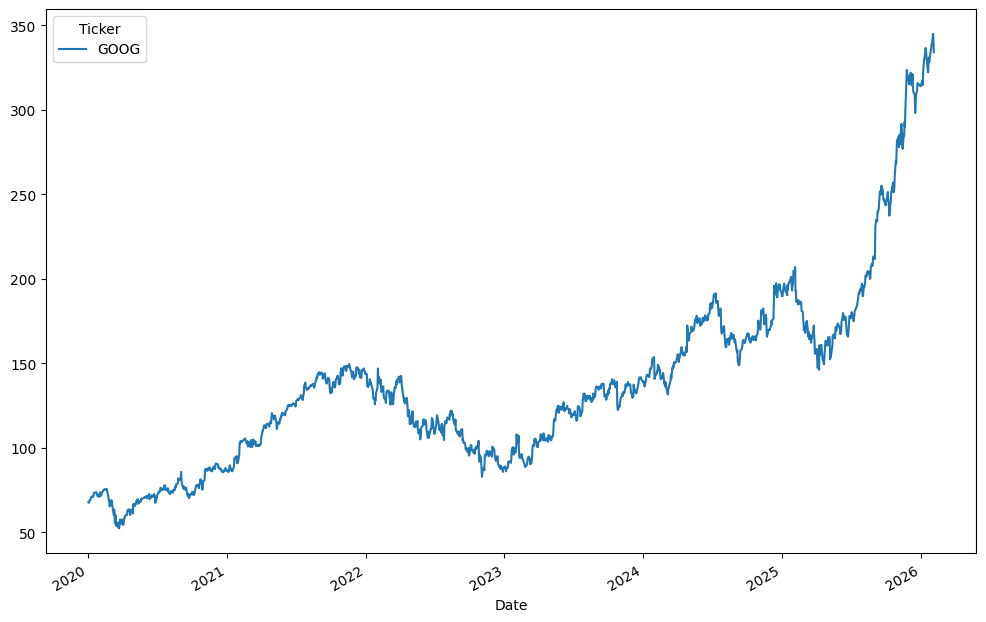

In [51]:
df.Close.plot(figsize=(12,8))

In [52]:
scaler = StandardScaler()

df['Close'] = scaler.fit_transform(df['Close'])

In [53]:
df.Close

Ticker,GOOG
Date,
2020-01-02,-1.260012
2020-01-03,-1.266049
2020-01-06,-1.235864
2020-01-07,-1.236647
2020-01-08,-1.226768
...,...
2026-01-29,3.649366
2026-01-30,3.647009
2026-02-02,3.762491


In [54]:
seq_length = 30
data = []

for i in range(len(df) - seq_length):
  data.append(df.Close[i:i+seq_length])

data = np.array(data)

In [55]:
data[:2]

array([[[-1.26001211],
        [-1.26604939],
        [-1.23586409],
        [-1.23664667],
        [-1.22676798],
        [-1.21281359],
        [-1.20390615],
        [-1.19535901],
        [-1.20287156],
        [-1.19538599],
        [-1.18413965],
        [-1.15832715],
        [-1.15471923],
        [-1.15332446],
        [-1.15269472],
        [-1.17063505],
        [-1.20015451],
        [-1.18336606],
        [-1.17790458],
        [-1.18041512],
        [-1.19985755],
        [-1.15333359],
        [-1.1883054 ],
        [-1.18726154],
        [-1.1620698 ],
        [-1.15937074],
        [-1.13287442],
        [-1.13277524],
        [-1.12424637],
        [-1.12749399]],

       [[-1.26604939],
        [-1.23586409],
        [-1.23664667],
        [-1.22676798],
        [-1.21281359],
        [-1.20390615],
        [-1.19535901],
        [-1.20287156],
        [-1.19538599],
        [-1.18413965],
        [-1.15832715],
        [-1.15471923],
        [-1.15332446],
        [

In [56]:
train_size = int(0.8 * len(data))

X_train = torch.from_numpy(data[:train_size, :-1, :]).type(torch.Tensor).to(device)
y_train = torch.from_numpy(data[:train_size, -1, :]).type(torch.Tensor).to(device)
X_test = torch.from_numpy(data[train_size:, :-1, :]).type(torch.Tensor).to(device)
y_test = torch.from_numpy(data[train_size:, -1, :]).type(torch.Tensor).to(device)

In [57]:
class PredictModel(nn.Module):
  def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
    super(PredictModel, self).__init__()

    self.num_layers = num_layers
    self.hidden_dim = hidden_dim

    self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device= device)
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device= device)

    out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
    out = self.fc(out[:, -1, :])

    return out

In [58]:
model = PredictModel(input_dim=1, hidden_dim=64, num_layers=2, output_dim=1)
model.to(device)

PredictModel(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [59]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [60]:
num_epochs = 200

for i in range(num_epochs):
  y_train_pred = model(X_train)

  loss = criterion(y_train_pred, y_train)

  if i % 25 == 0:
    print(f"Epoch: {i}, Loss: {loss.item()}")

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

Epoch: 0, Loss: 0.3960442543029785
Epoch: 25, Loss: 0.0116260452196002
Epoch: 50, Loss: 0.003631933592259884
Epoch: 75, Loss: 0.0030838109087198973
Epoch: 100, Loss: 0.002853567246347666
Epoch: 125, Loss: 0.0026867224369198084
Epoch: 150, Loss: 0.002529782010242343
Epoch: 175, Loss: 0.0023727708030492067


In [61]:
model.eval()

y_test_pred = model(X_test)

y_train_pred = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
y_train = scaler.inverse_transform(y_train.detach().cpu().numpy())
y_pred_test = scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
y_test = scaler.inverse_transform(y_test.detach().cpu().numpy())

In [62]:
train_rmse = root_mean_squared_error(y_train[:,0], y_train_pred[:,0])
test_rmse = root_mean_squared_error(y_test[:,0], y_pred_test[:,0])

In [63]:
train_rmse

2.5971248149871826

In [64]:
test_rmse

22.531492233276367

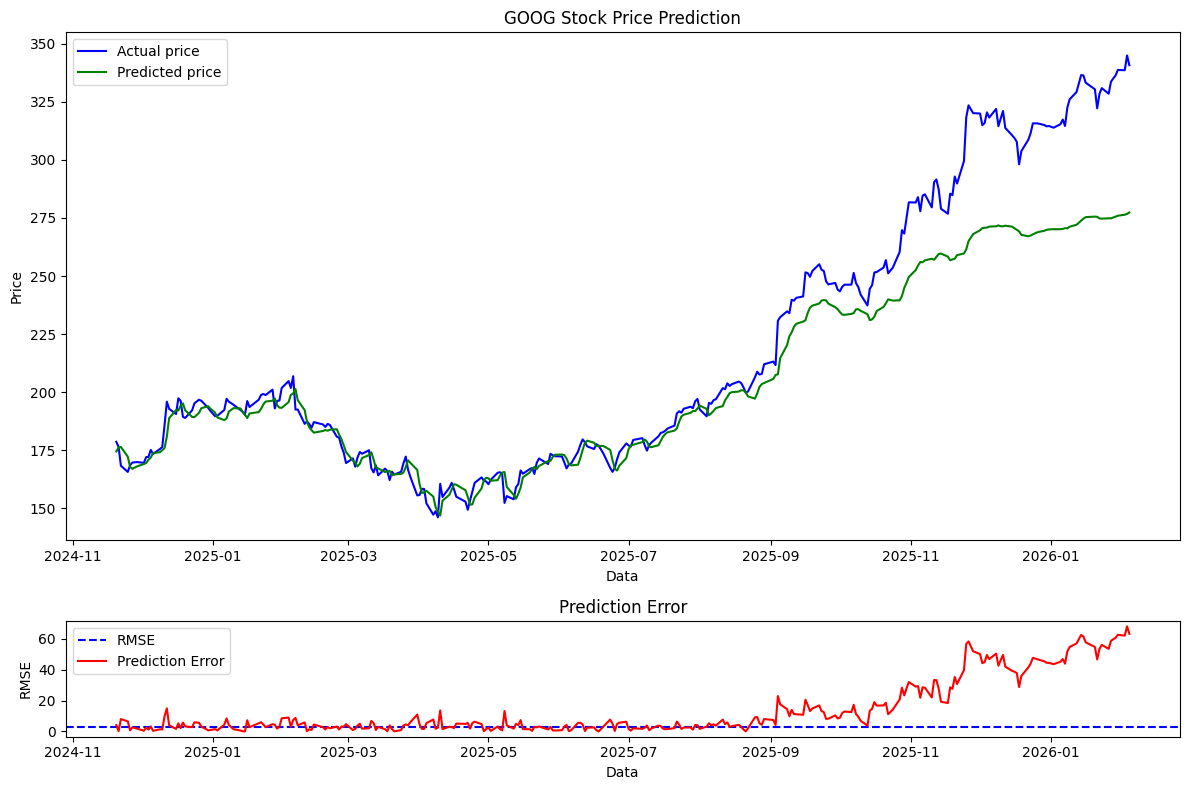

In [65]:
fig = plt.figure(figsize=(12,8))

gs = fig.add_gridspec(4,1)

ax1 = fig.add_subplot(gs[:3,0])
ax1.plot(df.iloc[-len(y_test):].index, y_test, color = 'blue', label = 'Actual price')
ax1.plot(df.iloc[-len(y_test):].index, y_pred_test, color = 'green', label = 'Predicted price')

ax1.legend()
plt.title(f"{ticker} Stock Price Prediction")
plt.xlabel('Data')
plt.ylabel('Price')

ax2 = fig.add_subplot(gs[3,0])
ax2.axhline(train_rmse, color='blue', linestyle='--', label = "RMSE")
ax2.plot(df[-len(y_test):].index, abs(y_test - y_pred_test), 'r', label = "Prediction Error")
ax2.legend()
plt.title('Prediction Error')
plt.xlabel('Data')
plt.ylabel('RMSE')

plt.tight_layout()
plt.show()